In [1]:
# Notebook settings in Colab...

# Runtime type          :  Python 3
# Hardware accelerator  :  GPU
# GPU type              :  T4
# GPU RAM               :  15 GB+

# If you use other notebook like Sagemaker, apply the same settings...

### Mounting Drive...

In [2]:
 # Mount Drive...

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# For Testing...

!ls "/content/gdrive/MyDrive/Greenox/Bottle_Data/"  # remove this ...

Test  train  val


In [4]:
# install the required libries...

!pip install roboflow faiss-gpu supervision -q

In [5]:
# importing...

import os
import faiss
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import supervision as sv

### Data Loading...
Filtering images which is not RGB.

In [6]:
# Constants...

ROOT_DIR = "/content/gdrive/MyDrive/Greenox/Bottle_Data/train/images/"
EMBEDDINGS_FILE = "all_embeddings.json"
INDEX_FILE = "data.bin"
IMG_SIZE = (416, 416)

In [7]:
# filter the images...

def get_files_in_directory(directory, extension=".jpg"):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.lower().endswith(extension)]
    return [f for f in files if Image.open(f).mode == 'RGB']

In [8]:
# Helper Functions...

def load_image(img_path: str) -> torch.Tensor:
    transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])
    img = Image.open(img_path)
    transformed_img = transform_image(img)[:3].unsqueeze(0)
    return transformed_img

### Build Model...

In [9]:
# Main Functionality...

class ImageFeatureExtractor:
    def __init__(self, model_name="facebookresearch/dinov2", model_variant="dinov2_vits14"):
        self.device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
        self.model = torch.hub.load(model_name, model_variant).to(self.device)

    def extract_features(self, image_paths):
        index = faiss.IndexFlatL2(384)
        all_embeddings = {}

        with torch.no_grad():
            for file in tqdm(image_paths):
                embeddings = self.model(load_image(file).to(self.device))
                embedding = embeddings[0].cpu().numpy()
                all_embeddings[file] = embedding.reshape(1, -1).tolist()
                index.add(embedding.reshape(1, -1))

        with open(EMBEDDINGS_FILE, "w") as f:
            f.write(json.dumps(all_embeddings))

        faiss.write_index(index, INDEX_FILE)

        return index, all_embeddings

    def retrieve_instances(self, query_image_path, top_k):
        with open(EMBEDDINGS_FILE, "r") as f:
            all_embeddings = json.load(f)

        index = faiss.read_index(INDEX_FILE)

        with torch.no_grad():
            embedding = self.model(load_image(query_image_path).to(self.device))
            D, I = index.search(embedding[0].cpu().numpy().reshape(1, -1), top_k)

        return I[0]


In [42]:
# Usage...

image_paths = get_files_in_directory(ROOT_DIR)
print("Total Images : {}\n".format(len(image_paths)))

feature_extractor = ImageFeatureExtractor()
feature_extractor.extract_features(image_paths)
top_k = 50 # Define the similar images needed...


Total Images : 11949



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


  0%|          | 0/11949 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
query_image_path = "/content/gdrive/MyDrive/Greenox/Bottle_Data/Test/bottle_1.jpg"
# query_image_path = "/content/gdrive/MyDrive/Greenox/Bottle_Data/Test/bottle_2.jpg"
# query_image_path = "/content/gdrive/MyDrive/Greenox/Bottle_Data/Test/bottle_3.jpg"

top_results = feature_extractor.retrieve_instances(query_image_path, top_k = top_k)

In [43]:
# Devide the List in set of 5 to plot properly...

my_list = np.array(top_results)
chunk_size = 5

result = np.array_split(my_list, len(my_list) / chunk_size)

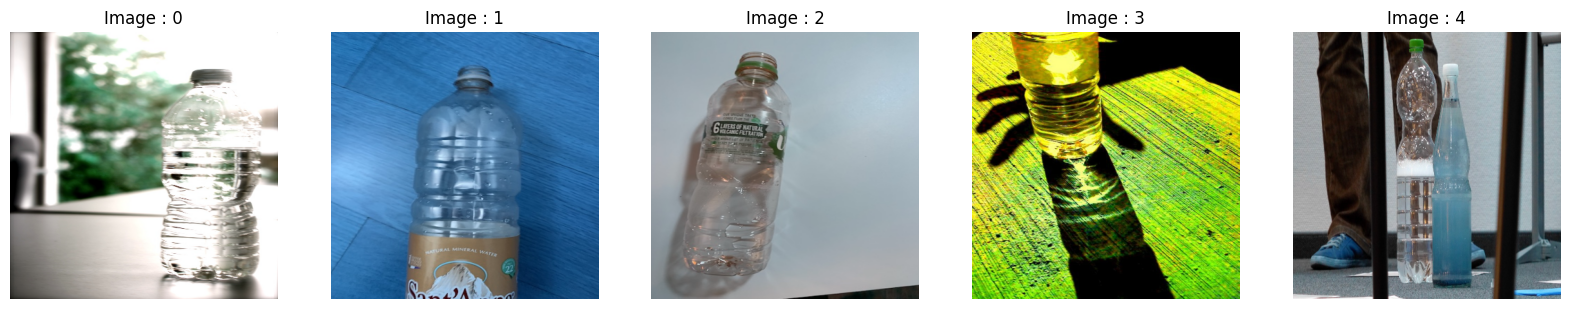

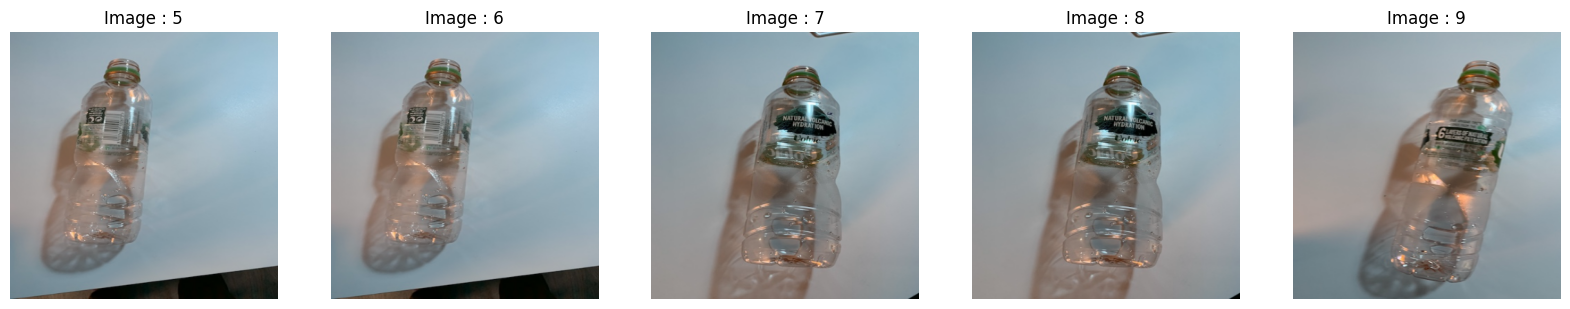

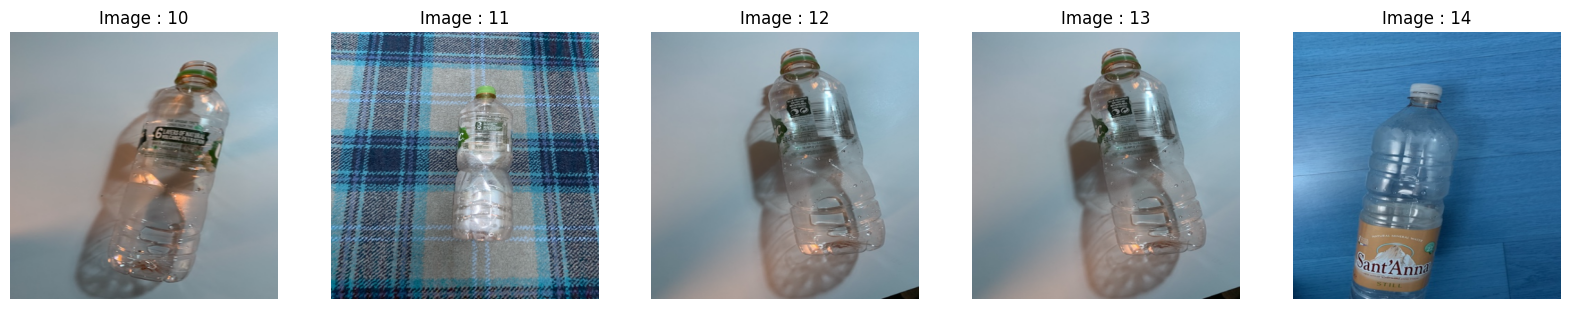

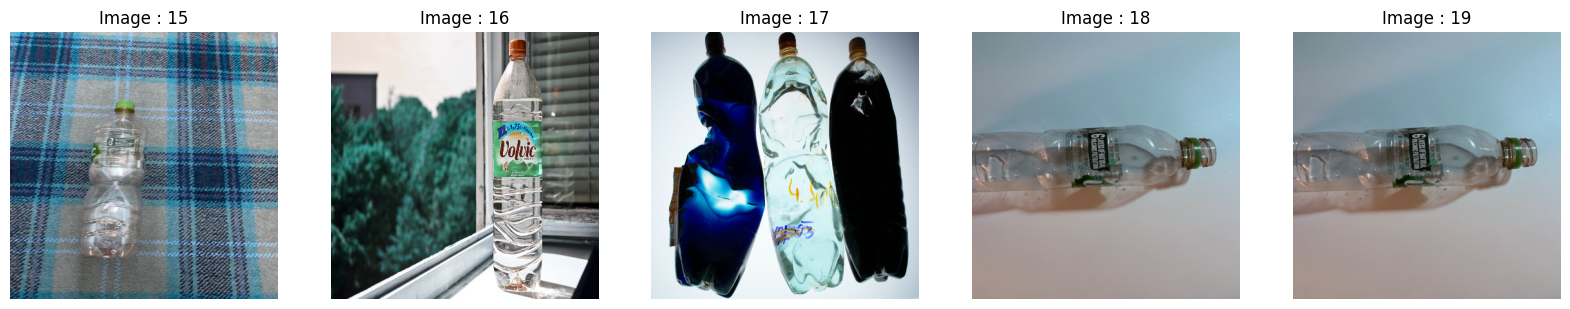

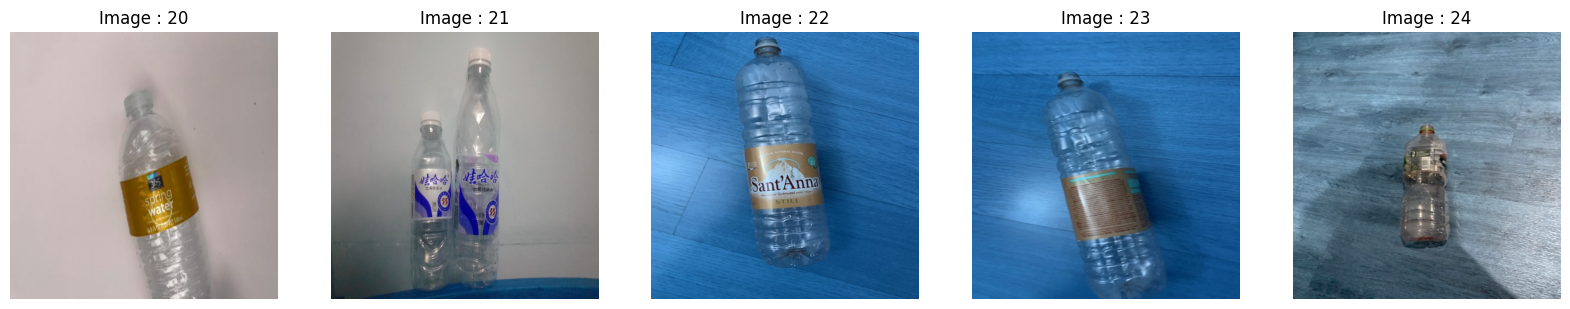

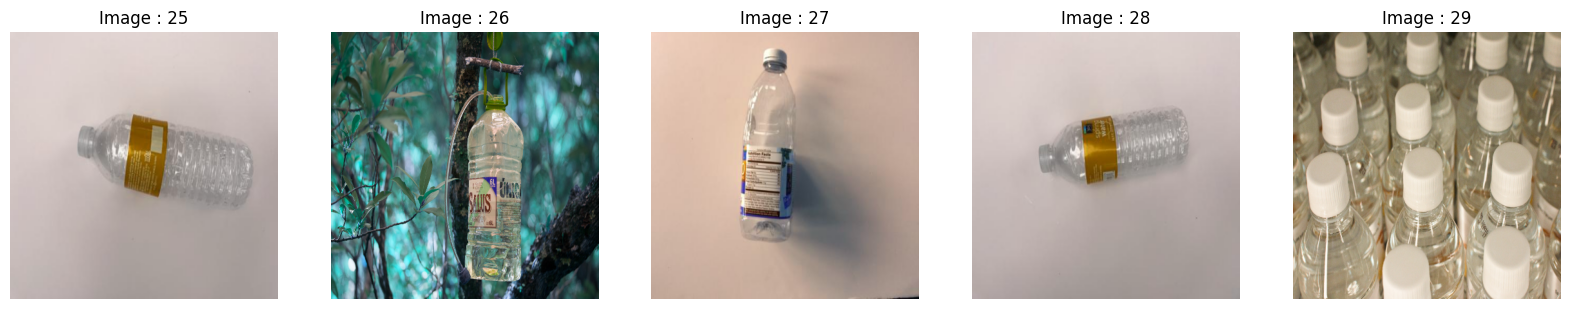

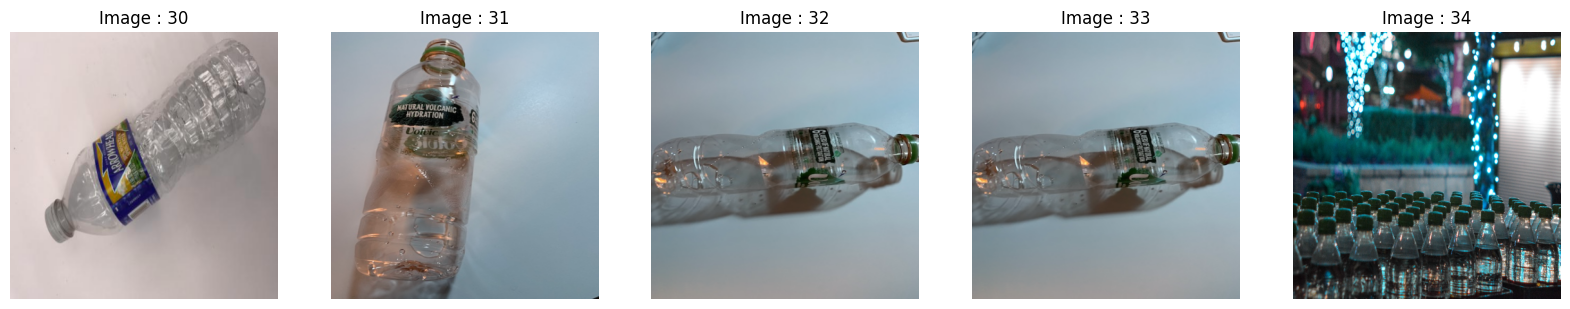

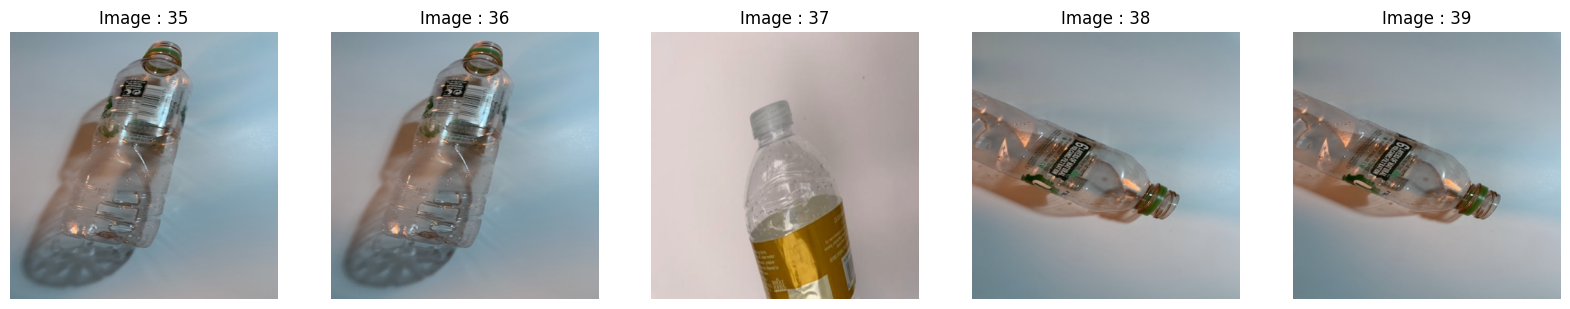

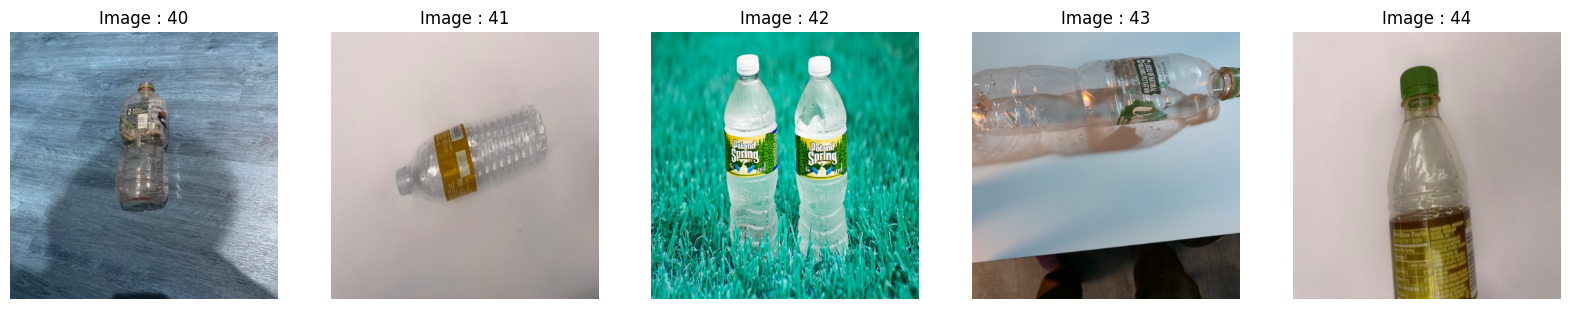

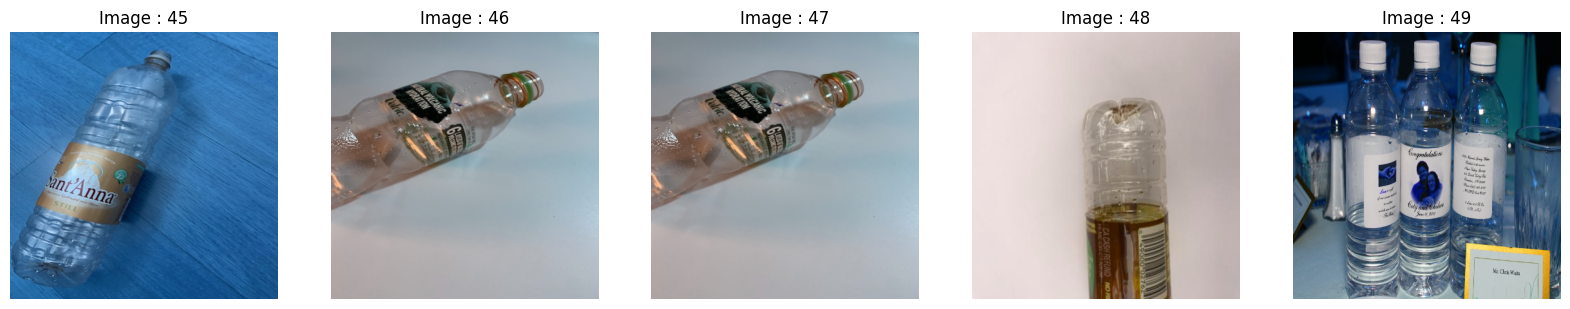

In [44]:
# Plotting the results...

rows = 1
columns = 5

n = 0
for j in result:
    pos = 0
    plt.figure(figsize=(20,110))
    for i, index in enumerate(j):
        img = cv2.resize(cv2.imread(image_paths[index]), IMG_SIZE)

        plt.subplot(rows, columns, pos + 1)
        im = plt.imshow(img)
        plt.title('Image : {}'.format(n))
        plt.axis('off')

        pos += 1
        n += 1
        if pos == 5:
            break

In [ ]:
# Done...